In [1]:
import pandas as pd
import numpy as np
import os
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from env import get_db_url
import acquire
import prepare

alpha = .05

## Acquire 

In [2]:
def get_telco_data():

    '''This function pulls telco data from the Codeup database and saves
    the file as a .csv'''
    filename = 'telco_data.csv'

    if os.path.isfile(filename):
        return pd.read_csv(filename)
    else:
       sql_query = '''SELECT * from customers
                JOIN contract_types using (contract_type_id)
                JOIN internet_service_types using (internet_service_type_id)
                JOIN payment_types using (payment_type_id)'''
       
    
    df = pd.read_sql(sql_query, get_db_url('telco_churn'))

    df.to_csv(filename)

    return df

In [3]:
df = acquire.get_telco_data()
df.head()

,Unnamed: 0,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,0,2,1,2,0002-ORFBO,Female,0,Yes,Yes,9,...,Yes,Yes,No,Yes,65.6,593.3,No,One year,DSL,Mailed check
1,1,2,1,1,0003-MKNFE,Male,0,No,No,9,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,DSL,Mailed check
2,2,1,2,1,0004-TLHLJ,Male,0,No,No,4,...,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Fiber optic,Electronic check
3,3,1,2,1,0011-IGKFF,Male,1,Yes,No,13,...,No,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Fiber optic,Electronic check
4,4,2,2,1,0013-EXCHZ,Female,1,Yes,No,3,...,Yes,Yes,No,Yes,83.9,267.4,Yes,Month-to-month,Fiber optic,Mailed check


## Prepare 

In [4]:
# replace empty cells with nulls
df = df.replace(' ', np.nan)

In [5]:
# check df for nulls
df.isna().sum()

Unnamed: 0                   0
payment_type_id              0
internet_service_type_id     0
contract_type_id             0
customer_id                  0
gender                       0
senior_citizen               0
partner                      0
dependents                   0
tenure                       0
phone_service                0
multiple_lines               0
online_security              0
online_backup                0
device_protection            0
tech_support                 0
streaming_tv                 0
streaming_movies             0
paperless_billing            0
monthly_charges              0
total_charges               11
churn                        0
contract_type                0
internet_service_type        0
payment_type                 0
dtype: int64

In [6]:
# drop 11 nulls from total_charges
df.dropna(inplace=True)

In [7]:
# check df for nulls
df.isna().sum()

Unnamed: 0                  0
payment_type_id             0
internet_service_type_id    0
contract_type_id            0
customer_id                 0
gender                      0
senior_citizen              0
partner                     0
dependents                  0
tenure                      0
phone_service               0
multiple_lines              0
online_security             0
online_backup               0
device_protection           0
tech_support                0
streaming_tv                0
streaming_movies            0
paperless_billing           0
monthly_charges             0
total_charges               0
churn                       0
contract_type               0
internet_service_type       0
payment_type                0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                7032 non-null   int64  
 1   payment_type_id           7032 non-null   int64  
 2   internet_service_type_id  7032 non-null   int64  
 3   contract_type_id          7032 non-null   int64  
 4   customer_id               7032 non-null   object 
 5   gender                    7032 non-null   object 
 6   senior_citizen            7032 non-null   int64  
 7   partner                   7032 non-null   object 
 8   dependents                7032 non-null   object 
 9   tenure                    7032 non-null   int64  
 10  phone_service             7032 non-null   object 
 11  multiple_lines            7032 non-null   object 
 12  online_security           7032 non-null   object 
 13  online_backup             7032 non-null   object 
 14  device_p

In [9]:
# change total_charges to float
df['total_charges'] = pd.to_numeric(df['total_charges'])

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,7032.0,3522.306314,2034.073173,0.00,1759.7500,3524.500,5283.2500,7042.00
payment_type_id,7032.0,2.315557,1.149523,1.00,1.0000,2.000,3.0000,4.00
internet_service_type_id,7032.0,1.872582,0.737271,1.00,1.0000,2.000,2.0000,3.00
contract_type_id,7032.0,1.688567,0.832934,1.00,1.0000,1.000,2.0000,3.00
senior_citizen,7032.0,0.162400,0.368844,0.00,0.0000,0.000,0.0000,1.00
tenure,7032.0,32.421786,24.545260,1.00,9.0000,29.000,55.0000,72.00
monthly_charges,7032.0,64.798208,30.085974,18.25,35.5875,70.350,89.8625,118.75
total_charges,7032.0,2283.300441,2266.771362,18.80,401.4500,1397.475,3794.7375,8684.80


In [11]:
# determine columns to drop
# Unnamed: 0 (note needed)	payment_type_id	internet_service_type_id	contract_type_id (already in additional columns)
df = df.drop(columns=['Unnamed: 0', 'payment_type_id', 'internet_service_type_id', 'contract_type_id'])

In [12]:
# convert categorical columns to boolean
df['is_female'] = df['gender'].map({'Female': 1, 'Male': 0})
df['has_partner'] = df['partner'].map({'Yes': 1, 'No': 0})
df['has_dependents'] = df['dependents'].map({'Yes': 1, 'No': 0})
df['has_phone_service'] = df['phone_service'].map({'Yes': 1, 'No': 0})
df['has_paperless_billing'] = df['paperless_billing'].map({'Yes': 1, 'No': 0})
df['has_churned'] = df['churn'].map({'Yes': 1, 'No': 0})

df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,churn,contract_type,internet_service_type,payment_type,is_female,has_partner,has_dependents,has_phone_service,has_paperless_billing,has_churned
0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,No,Yes,...,No,One year,DSL,Mailed check,1,1,1,1,1,0
1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,No,No,...,No,Month-to-month,DSL,Mailed check,0,0,0,1,0,0
2,0004-TLHLJ,Male,0,No,No,4,Yes,No,No,No,...,Yes,Month-to-month,Fiber optic,Electronic check,0,0,0,1,1,1
3,0011-IGKFF,Male,1,Yes,No,13,Yes,No,No,Yes,...,Yes,Month-to-month,Fiber optic,Electronic check,0,1,0,1,1,1
4,0013-EXCHZ,Female,1,Yes,No,3,Yes,No,No,No,...,Yes,Month-to-month,Fiber optic,Mailed check,1,1,0,1,1,1


In [13]:
dummy_df = pd.get_dummies(df[['contract_type','internet_service_type', 'payment_type',\
                              'multiple_lines', 'online_security', 'online_backup',\
                              'tech_support', 'streaming_tv', 'streaming_movies']],dummy_na=False, drop_first=True)

In [14]:
df = pd.concat([df, dummy_df], axis=1)
df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,online_security_No internet service,online_security_Yes,online_backup_No internet service,online_backup_Yes,tech_support_No internet service,tech_support_Yes,streaming_tv_No internet service,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes
0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,No,Yes,...,0,0,0,1,0,1,0,1,0,0
1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,No,No,...,0,0,0,0,0,0,0,0,0,1
2,0004-TLHLJ,Male,0,No,No,4,Yes,No,No,No,...,0,0,0,0,0,0,0,0,0,0
3,0011-IGKFF,Male,1,Yes,No,13,Yes,No,No,Yes,...,0,0,0,1,0,0,0,1,0,1
4,0013-EXCHZ,Female,1,Yes,No,3,Yes,No,No,No,...,0,0,0,0,0,1,0,1,0,0


In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
senior_citizen,7032.0,0.162400,0.368844,0.00,0.0000,0.000,0.0000,1.00
tenure,7032.0,32.421786,24.545260,1.00,9.0000,29.000,55.0000,72.00
monthly_charges,7032.0,64.798208,30.085974,18.25,35.5875,70.350,89.8625,118.75
total_charges,7032.0,2283.300441,2266.771362,18.80,401.4500,1397.475,3794.7375,8684.80
is_female,7032.0,0.495307,0.500014,0.00,0.0000,0.000,1.0000,1.00
has_partner,7032.0,0.482509,0.499729,0.00,0.0000,0.000,1.0000,1.00
has_dependents,7032.0,0.298493,0.457629,0.00,0.0000,0.000,1.0000,1.00
has_phone_service,7032.0,0.903299,0.295571,0.00,1.0000,1.000,1.0000,1.00
has_paperless_billing,7032.0,0.592719,0.491363,0.00,0.0000,1.000,1.0000,1.00
has_churned,7032.0,0.265785,0.441782,0.00,0.0000,0.000,1.0000,1.00


In [16]:
train_validate, test = train_test_split(df, test_size=.2, 
                                        random_state=123, 
                                        stratify=df.churn)
train, validate = train_test_split(train_validate, test_size=.3, 
                                   random_state=123, 
                                   stratify=train_validate.churn)


In [17]:
train.shape, validate.shape, test.shape

((3937, 46), (1688, 46), (1407, 46))

In [18]:
# confirm data was stratified
train.churn.value_counts(normalize=True), validate.churn.value_counts(normalize=True), test.churn.value_counts(normalize=True)

(No     0.734315
 Yes    0.265685
 Name: churn, dtype: float64,
 No     0.734005
 Yes    0.265995
 Name: churn, dtype: float64,
 No     0.734186
 Yes    0.265814
 Name: churn, dtype: float64)

In [19]:
def clean_telco_data(df):
    # replace empty cells with nulls
    df = df.replace(' ', np.nan)
    # drop 11 nulls from total_charges
    df.dropna(inplace=True)
    # change total_charges to float
    df['total_charges'] = pd.to_numeric(df['total_charges'])
    # drop unnecessary columns
    df = df.drop(columns=['Unnamed: 0', 'payment_type_id', 'internet_service_type_id', 'contract_type_id'])
    # convert categorical columns to boolean
    df['is_female'] = df['gender'].map({'Female': 1, 'Male': 0})
    df['has_partner'] = df['partner'].map({'Yes': 1, 'No': 0})
    df['has_dependents'] = df['dependents'].map({'Yes': 1, 'No': 0})
    df['has_phone_service'] = df['phone_service'].map({'Yes': 1, 'No': 0})
    df['has_paperless_billing'] = df['paperless_billing'].map({'Yes': 1, 'No': 0})
    df['has_churned'] = df['churn'].map({'Yes': 1, 'No': 0})
    
    # encode categorical columns 
    dummy_df = pd.get_dummies(df[['contract_type','internet_service_type', 'payment_type',\
                              'multiple_lines', 'online_security', 'online_backup',\
                              'tech_support', 'streaming_tv', 'streaming_movies']],dummy_na=False, drop_first=False)
    #combine dataframes
    df = pd.concat([df, dummy_df], axis=1)
    
    return df
    


In [20]:
def prep_telco_data(df):
    df = clean_titanic_data(df)
    train_validate, test = train_test_split(df, test_size=.2, 
                                        random_state=123, 
                                        stratify=df.churn)
    train, validate = train_test_split(train_validate, test_size=.3, 
                                   random_state=123, 
                                   stratify=train_validate.churn)
    
    return train, validate, test
    

## Explore
    

In [21]:
df.corr()

,senior_citizen,tenure,monthly_charges,total_charges,is_female,has_partner,has_dependents,has_phone_service,has_paperless_billing,has_churned,...,online_security_No internet service,online_security_Yes,online_backup_No internet service,online_backup_Yes,tech_support_No internet service,tech_support_Yes,streaming_tv_No internet service,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes
senior_citizen,1.000000,0.015683,0.219874,0.102411,0.001819,0.016957,-0.210550,0.008392,0.156258,0.150541,...,-0.182519,-0.038576,-0.182519,0.066663,-0.182519,-0.060577,-0.182519,0.105445,-0.182519,0.119842
tenure,0.015683,1.000000,0.246862,0.825880,-0.005285,0.381912,0.163386,0.007877,0.004823,-0.354049,...,-0.037529,0.328297,-0.037529,0.361138,-0.037529,0.325288,-0.037529,0.280264,-0.037529,0.285402
monthly_charges,0.219874,0.246862,1.000000,0.651065,0.013779,0.097825,-0.112343,0.248033,0.351930,0.192858,...,-0.763191,0.296447,-0.763191,0.441529,-0.763191,0.338301,-0.763191,0.629668,-0.763191,0.627235
total_charges,0.102411,0.825880,0.651065,1.000000,-0.000048,0.319072,0.064653,0.113008,0.157830,-0.199484,...,-0.374878,0.412619,-0.374878,0.510100,-0.374878,0.432868,-0.374878,0.515709,-0.374878,0.519867
is_female,0.001819,-0.005285,0.013779,-0.000048,1.000000,0.001379,-0.010349,0.007515,0.011902,0.008545,...,-0.004745,0.016328,-0.004745,0.013093,-0.004745,0.008507,-0.004745,0.007124,-0.004745,0.010105
has_partner,0.016957,0.381912,0.097825,0.319072,0.001379,1.000000,0.452269,0.018397,-0.013957,-0.149982,...,-0.000286,0.143346,-0.000286,0.141849,-0.000286,0.120206,-0.000286,0.124483,-0.000286,0.118108
has_dependents,-0.210550,0.163386,-0.112343,0.064653,-0.010349,0.452269,1.000000,-0.001078,-0.110131,-0.163128,...,0.138383,0.080786,0.138383,0.023639,0.138383,0.063053,0.138383,-0.016499,0.138383,-0.038375
has_phone_service,0.008392,0.007877,0.248033,0.113008,0.007515,0.018397,-0.001078,1.000000,0.016696,0.011691,...,0.171817,-0.091676,0.171817,-0.052133,0.171817,-0.095138,0.171817,-0.021383,0.171817,-0.033477
has_paperless_billing,0.156258,0.004823,0.351930,0.157830,0.011902,-0.013957,-0.110131,0.016696,1.000000,0.191454,...,-0.320592,-0.004051,-0.320592,0.127056,-0.320592,0.037536,-0.320592,0.224241,-0.320592,0.211583
has_churned,0.150541,-0.354049,0.192858,-0.199484,0.008545,-0.149982,-0.163128,0.011691,0.191454,1.000000,...,-0.227578,-0.171270,-0.227578,-0.082307,-0.227578,-0.164716,-0.227578,0.063254,-0.227578,0.060860


In [22]:
train.churn.value_counts()

No     2891
Yes    1046
Name: churn, dtype: int64

<AxesSubplot:>

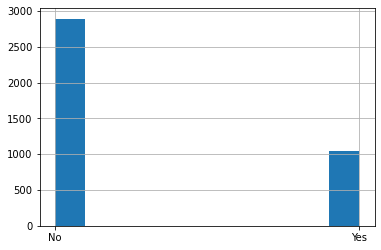

In [23]:
train.churn.hist()

<AxesSubplot:xlabel='gender', ylabel='has_churned'>

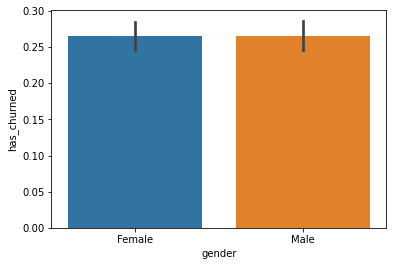

In [24]:
sns.barplot(data=train, x = 'gender', y = 'has_churned')

Gender does not appear to affect churn.

<AxesSubplot:xlabel='churn', ylabel='monthly_charges'>

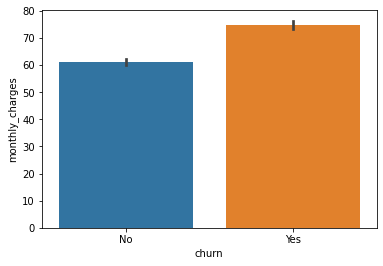

In [25]:
sns.barplot(data=train, y='monthly_charges', x='churn')

<AxesSubplot:xlabel='churn', ylabel='monthly_charges'>

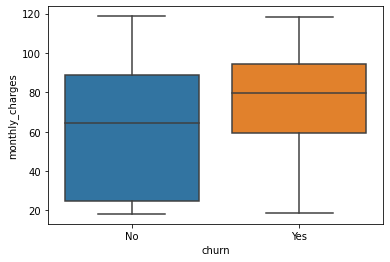

In [26]:
sns.boxplot(data=train,  y='monthly_charges', x='churn')

Those that churn have, on average, higher monthly bills.

<AxesSubplot:xlabel='contract_type', ylabel='count'>

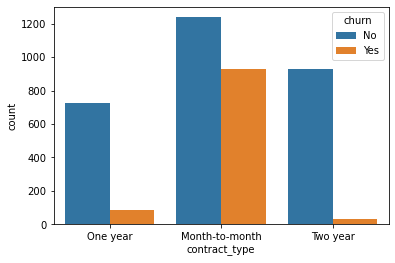

In [27]:
sns.countplot(data=train, x='contract_type', hue='churn')

Customers with month-to-month contracts are more likely to churn.

<AxesSubplot:xlabel='senior_citizen', ylabel='count'>

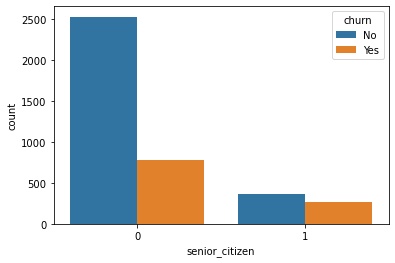

In [28]:
sns.countplot(data=train, x='senior_citizen', hue ='churn')

Senior citizens are more likely to churn.

<AxesSubplot:xlabel='dependents', ylabel='count'>

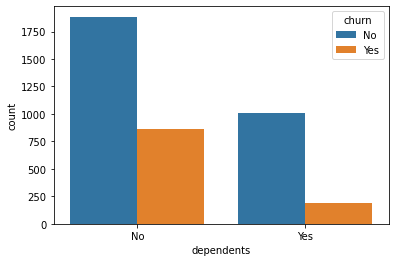

In [29]:
sns.countplot(data=train, x='dependents', hue ='churn')

Customers without dependents are more likely to churn.

<AxesSubplot:xlabel='partner', ylabel='count'>

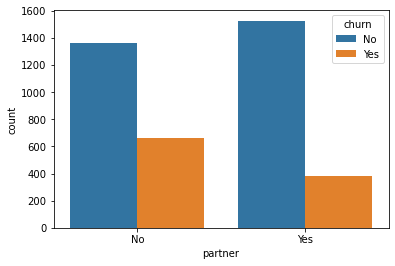

In [30]:
sns.countplot(data=train, x='partner', hue ='churn')

Customers without partners are more likely to churn.

<AxesSubplot:xlabel='churn', ylabel='count'>

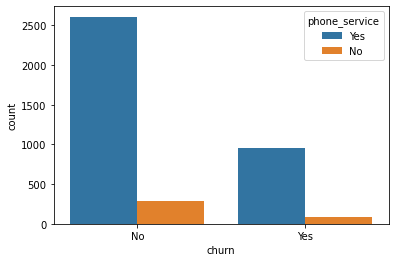

In [31]:
sns.countplot(data=train, x='churn', hue ='phone_service')

Phone service does not appear to be a predictor of churn.

<AxesSubplot:xlabel='churn', ylabel='count'>

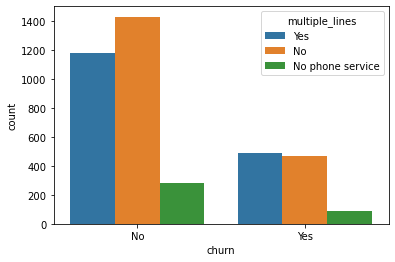

In [32]:
sns.countplot(data=train, x='churn', hue ='multiple_lines')

Having multiples lines does not appear to be a predictor of churn.

<AxesSubplot:xlabel='churn', ylabel='count'>

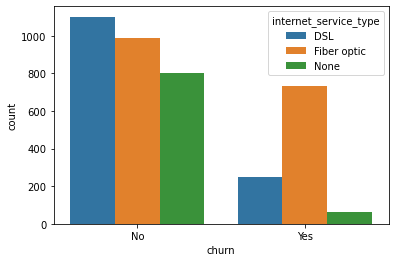

In [33]:
sns.countplot(data=train, x='churn', hue ='internet_service_type')

Those with Fiber optic internet are more likely to churn.

<AxesSubplot:xlabel='churn', ylabel='count'>

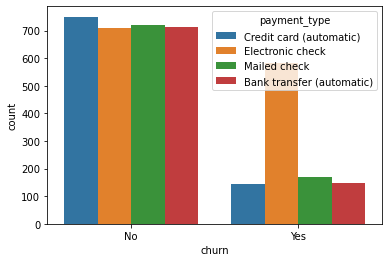

In [34]:
sns.countplot(data=train, x='churn', hue ='payment_type')

Customers that pay with electronic check are more likely to churn.

Text(0.5, 1.0, 'Customers without online security are more likely to churn')

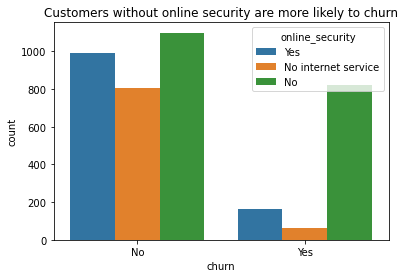

In [35]:
# explore add-on services
sns.countplot(data=train, x='churn', hue ='online_security')
plt.title('Customers without online security are more likely to churn')

Customers without online security are more likely to churn.

<AxesSubplot:xlabel='churn', ylabel='count'>

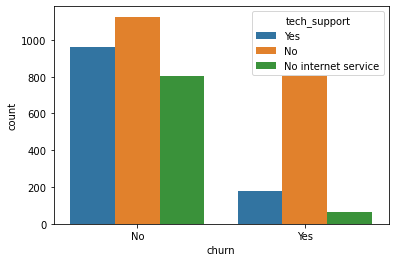

In [36]:
sns.countplot(data=train, x='churn', hue ='tech_support')

Customers without tech support are more likely to churn.

<AxesSubplot:xlabel='churn', ylabel='count'>

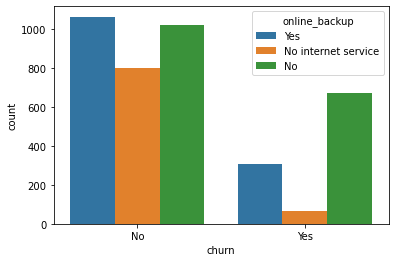

In [37]:
sns.countplot(data=train, x='churn', hue ='online_backup')

Text(-0.77, 1.0, 'Customers without add-on services churn more often')

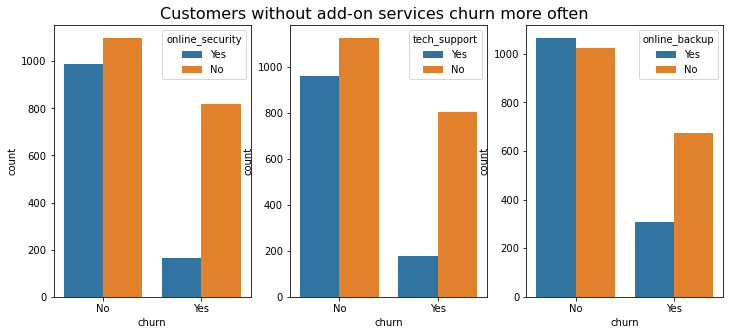

In [38]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(12, 5)
#create chart in each subplot

sns.countplot(data=train[-(train.online_backup== 'No internet service')], x='churn', hue ='online_security',ax=axes[0])
sns.countplot(data=train[-(train.online_backup== 'No internet service')], x='churn', hue ='tech_support',ax=axes[1])
sns.countplot(data=train[-(train.online_backup== 'No internet service')], x='churn', hue ='online_backup',ax=axes[2])

plt.title('Customers without add-on services churn more often', x=-.77, fontsize = 16)

In [41]:
train['has_churned'].corr(train['tech_support_Yes']),train['has_churned'].corr(train['online_backup_Yes']), train['has_churned'].corr(train['online_security_Yes'])

(-0.1593052946345446, -0.06851944223502447, -0.18083436042010895)

In [ ]:
no_add_ons = train[(train.online_security == 'No')&(train.online_backup == 'No')&(train.tech_support == 'No')]

Customers without online backup are more likely to churn.

In [ ]:
sns.countplot(data=train, x='churn', hue ='streaming_tv')

In [ ]:
(train[train.churn == 'Yes'].streaming_tv == 'No').value_counts(normalize=True)

Customers without streaming tv are more likely to churn.

In [ ]:
sns.countplot(data=train, x='churn', hue ='streaming_movies')

Customers without streaming movies are more likely to churn.

## Hypothesis Testing

### T -Test

In [ ]:
train.monthly_charges.hist()

In [ ]:
churned = train[train.churn == 'Yes'].monthly_charges

churned.hist()


Null hypothesis: The mean of monthly charges of churned customers <= the mean of monthly charges of all customers

Alternative hypothesis: The meean of monthly charges of churned customers > the mean of monthly charges of all customers

In [ ]:
churned = train[train.churn == 'Yes'].monthly_charges
pop_mean = train.monthly_charges.mean()

t, p = stats.ttest_1samp(churned, pop_mean)

t,p


In [ ]:
if p/2 > alpha:
    print("Fail to reject the null")
elif t < 0:
    print("Fail to reject the null")
else:
    print("Reject the null")

Null hypothesis: The mean of the tenure of churned customers >= the mean of the tenure of all customers

Alternative hypothesis: The mean of the tenure of churned customers < the mean of the tenure of all customers

In [ ]:
churned = train[train.churn == 'Yes'].tenure
pop_mean = train.tenure.mean()

t, p = stats.ttest_1samp(churned, pop_mean)

t,p


In [ ]:
if p/2 > alpha:
    print("Fail to reject the null")
elif t > 0:
    print("Fail to reject the null")
else:
    print("Reject the null")

### Chi- Squared

Null Hypothesis: Churn and being a senior citizen are independent.

Alternative Hypothesis: Churn and being a senior citizen are dependent.

In [ ]:
observed = pd.crosstab(train.senior_citizen, train.churn)

In [ ]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
p

In [ ]:
if p < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null")

Null Hypothesis: Churn and having dependents are independent.

Alternative Hypothesis: Churn and having dependents are dependent.

In [ ]:
observed = pd.crosstab(train.dependents, train.churn)
observed

In [ ]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
p

In [ ]:
if p < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null")

Null Hypothesis: Churn and having a partner are independent.

Alternative Hypothesis: Churn and having a partner are dependent.

In [ ]:
observed = pd.crosstab(train.partner, train.churn)
observed

In [ ]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
p

In [ ]:
if p < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null")

Null Hypothesis: Churn and internet service type are independent.

Alternative Hypothesis: Churn and internet service type are dependent.

In [ ]:
observed = pd.crosstab(train.internet_service_type, train.churn)

In [ ]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
p

In [ ]:
if p < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null")

Null Hypothesis: Churn and having fiber optic internet are independent.

Alternative Hypothesis: Churn and having fiber optic internet are dependent.

In [ ]:
observed = pd.crosstab(train.internet_service_type == 'Fiber optic', train.churn)

In [ ]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
p

In [ ]:
if p < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null")

Null hypothesis: Churn and payment type are independent.

Alternative hypothesis: Churn and payment type are dependent.

In [ ]:
observed = pd.crosstab(train.payment_type, train.churn)
observed

In [ ]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
p

In [ ]:
if p < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null")

Null hypothesis: Churn and electronic check payments are independent.

Alternative hypothesis: Churn and electronic check payments are dependent.

In [ ]:
observed = pd.crosstab(train.payment_type == 'Electronic check', train.churn)
observed

In [ ]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
p

In [ ]:
if p < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null")

Null hypothesis: Churn and online security are independent.

Alternative hypothesis: Churn and online security are dependent.

In [ ]:
observed = pd.crosstab(train.online_security, train.churn)
observed

In [ ]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
p

In [ ]:
if p < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null")

Null hypothesis: Churn and online backup are independent.

Alternative hypothesis: Churn and online backup are dependent.

In [ ]:
observed = pd.crosstab(train.online_backup, train.churn)
observed

In [ ]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
p

In [ ]:
if p < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null")

Null hypothesis: Churn and tech support are independent.

Alternative hypothesis: Churn and tech support are dependent.

In [ ]:
observed = pd.crosstab(train.tech_support, train.churn)
observed

In [ ]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
p

In [ ]:
if p < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null")

### Takeaways

Key indicators for churn are:

        Family type:
            Seniors, those without partners, and those without dependents are more likely to churn.
            
        Monthly charges:
            Those with higher monthly charges are more likely to churn.
            
        Payment type:
            Those with electronic checks are more likely to churn.
            
        Internet type:
            Customers with fiber optic internet churn at a higher rate.
            
        Add-ons:
            Customers without tech support, online backup, or online security churn at higher rates.
        

## Modeling

True Positive: Predicted that a customer has churned and they did.

False Positive: Predicted that a customer has churned and they did not.

True Negative: Predicted that a customer had not churned and they did not.

False Negative: Predicted that a customer had not churned and they did.

In [ ]:
# determine baseline accuracy
train.has_churned.value_counts(normalize=True)

The baseline model is 73% accurate assuming that 0 customers churn.

### Decision Tree

- The best model optimized for accuracy has a max depth of 4 with a train accuracy of 80% and a validation accuracy of 78%	which out performs the baseline model. 


In [ ]:
# create X & y version of train, where y is a series with just the target variable and X are all the features. 

X_train = train.drop(columns=['customer_id', 'gender', 'partner', 'dependents',\
                              'phone_service', 'multiple_lines', 'online_security',\
                              'online_backup', 'device_protection', 'tech_support', 'streaming_tv',\
                              'streaming_movies', 'paperless_billing', 'churn', 'contract_type',\
                              'internet_service_type', 'payment_type', 'has_churned', 'is_female'])
y_train = train.has_churned

X_validate = validate.drop(columns=['customer_id', 'gender', 'partner', 'dependents',\
                              'phone_service', 'multiple_lines', 'online_security',\
                              'online_backup', 'device_protection', 'tech_support', 'streaming_tv',\
                              'streaming_movies', 'paperless_billing', 'churn', 'contract_type',\
                              'internet_service_type', 'payment_type', 'has_churned', 'is_female'])
y_validate = validate.has_churned

X_test = test.drop(columns=['customer_id', 'gender', 'partner', 'dependents',\
                              'phone_service', 'multiple_lines', 'online_security',\
                              'online_backup', 'device_protection', 'tech_support', 'streaming_tv',\
                              'streaming_movies', 'paperless_billing', 'churn', 'contract_type',\
                              'internet_service_type', 'payment_type', 'has_churned', 'is_female'])
y_test = test.has_churned

In [ ]:
# create the decision tree
clf = DecisionTreeClassifier(max_depth=4, random_state=123)

In [ ]:
# fit the model
clf = clf.fit(X_train, y_train)

In [ ]:
# visualize the decision tree
plt.figure(figsize=(13, 7))
plot_tree(clf, feature_names=X_train.columns, class_names = clf.classes_.astype(str), rounded=True)


In [ ]:
# make prediction on train obeservations

y_pred1 = clf.predict(X_train)
y_pred1[0:5]


In [ ]:
y_pred_proba1 = clf.predict_proba(X_train)
y_pred_proba1[0:5]


In [ ]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))

My deicision tree model beats baseline.

In [ ]:
# confusion matrix

confusion_matrix(y_train, y_pred1)


In [ ]:
print(classification_report(y_train, y_pred1))

In [ ]:
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
     .format(clf.score(X_validate, y_validate)))


In [ ]:
y_pred_val = clf.predict(X_validate)
print(classification_report(y_validate, y_pred_val))

In [ ]:
for i in range(2, 21):
    # Make the model
    tree = DecisionTreeClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    tree = tree.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    y_predictions = tree.predict(X_train)

    # Produce the classification report on the actual y values and this model's predicted y values
    report = classification_report(y_train, y_predictions, output_dict=True)
    print(f"Tree with max depth of {i}")
    print(pd.DataFrame(report))
    print()

In [ ]:
# Compare accuracy for in-sample and out-of-sample data
metrics = []

for i in range(2, 19):
    # Make the model
    tree = DecisionTreeClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    tree = tree.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = tree.score(X_train, y_train)
    
    out_of_sample_accuracy = tree.score(X_validate, y_validate)

    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

In [ ]:
# create the decision tree
clf = DecisionTreeClassifier(max_depth=9, random_state=123)

# fit the model
clf = clf.fit(X_train, y_train)

# visualize the decision tree
plt.figure(figsize=(13, 7))
plot_tree(clf, feature_names=X_train.columns, class_names = clf.classes_.astype(str), rounded=True)


# make prediction on train obeservations

y_pred2 = clf.predict(X_train)
y_pred[0:5]


y_pred_proba2 = clf.predict_proba(X_train)
y_pred_proba[0:5]


print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))




In [ ]:
print(classification_report(y_train, y_pred2))

In [ ]:
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
     .format(clf.score(X_validate, y_validate)))


In [ ]:
y_pred2=clf.predict(X_validate)

In [ ]:
print(classification_report(y_validate, y_pred2))

### Random Forest

In [ ]:
# create X & y version of train, where y is a series with just the target variable and X are all the features. 

X_train = train.drop(columns=['customer_id', 'gender', 'partner', 'dependents',\
                              'phone_service', 'multiple_lines', 'online_security',\
                              'online_backup', 'device_protection', 'tech_support', 'streaming_tv',\
                              'streaming_movies', 'paperless_billing', 'churn', 'contract_type',\
                              'internet_service_type', 'payment_type', 'has_churned', 'is_female'])
y_train = train.has_churned

X_validate = validate.drop(columns=['customer_id', 'gender', 'partner', 'dependents',\
                              'phone_service', 'multiple_lines', 'online_security',\
                              'online_backup', 'device_protection', 'tech_support', 'streaming_tv',\
                              'streaming_movies', 'paperless_billing', 'churn', 'contract_type',\
                              'internet_service_type', 'payment_type', 'has_churned', 'is_female'])
y_validate = validate.has_churned

X_test = test.drop(columns=['customer_id', 'gender', 'partner', 'dependents',\
                              'phone_service', 'multiple_lines', 'online_security',\
                              'online_backup', 'device_protection', 'tech_support', 'streaming_tv',\
                              'streaming_movies', 'paperless_billing', 'churn', 'contract_type',\
                              'internet_service_type', 'payment_type', 'has_churned', 'is_female'])
y_test = test.has_churned

In [ ]:
rf = RandomForestClassifier(max_depth=4, random_state=123)


In [ ]:
rf.fit(X_train, y_train)


In [ ]:
print(rf.feature_importances_)


In [ ]:
y_pred = rf.predict(X_train)
y_pred[0:5]

In [ ]:
y_pred_proba = rf.predict_proba(X_train)
y_pred_proba[0:5]

In [ ]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))


In [ ]:
print(classification_report(y_train, y_pred))


In [ ]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(X_validate, y_validate)))


In [ ]:
y_pred = rf.predict(X_validate)

In [ ]:
print(classification_report(y_validate, y_pred))

In [ ]:
metrics = []

for i in range(2, 19):
    # Make the model
    forest = RandomForestClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = forest.score(X_train, y_train)
    
    out_of_sample_accuracy = forest.score(X_validate, y_validate)

    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

### K- Nearest Neighbor

- The best KNN model is when k = 8	with a training accuracy of 81% and a validation accuracy of 78%. Recall rate on validation data for the positive case is 43%.

In [ ]:
# create X & y version of train, where y is a series with just the target variable and X are all the features. 

X_train = train.drop(columns=['customer_id', 'gender', 'partner', 'dependents',\
                              'phone_service', 'multiple_lines', 'online_security',\
                              'online_backup', 'device_protection', 'tech_support', 'streaming_tv',\
                              'streaming_movies', 'paperless_billing', 'churn', 'contract_type',\
                              'internet_service_type', 'payment_type', 'has_churned', 'is_female'])
y_train = train.has_churned

X_validate = validate.drop(columns=['customer_id', 'gender', 'partner', 'dependents',\
                              'phone_service', 'multiple_lines', 'online_security',\
                              'online_backup', 'device_protection', 'tech_support', 'streaming_tv',\
                              'streaming_movies', 'paperless_billing', 'churn', 'contract_type',\
                              'internet_service_type', 'payment_type', 'has_churned', 'is_female'])
y_validate = validate.has_churned

X_test = test.drop(columns=['customer_id', 'gender', 'partner', 'dependents',\
                              'phone_service', 'multiple_lines', 'online_security',\
                              'online_backup', 'device_protection', 'tech_support', 'streaming_tv',\
                              'streaming_movies', 'paperless_billing', 'churn', 'contract_type',\
                              'internet_service_type', 'payment_type', 'has_churned', 'is_female'])
y_test = test.has_churned

In [ ]:
knn = KNeighborsClassifier(n_neighbors=15, weights='uniform')

In [ ]:
knn.fit(X_train, y_train)


In [ ]:
y_pred = knn.predict(X_train)
y_pred[0:5]

In [ ]:
y_pred_proba = knn.predict_proba(X_train)
y_pred_proba[0:5]

In [ ]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))


In [ ]:
print(classification_report(y_train, y_pred))


In [ ]:
print('Accuracy of KNN classifier on validate set: {:.2f}'
     .format(knn.score(X_validate, y_validate)))


In [ ]:
metrics = []

# loop through different values of k
for k in range(3, 21):
            
    # define the thing
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # fit the thing (remmeber only fit on training data)
    knn.fit(X_train, y_train)
    
    # use the thing (calculate accuracy)
    train_accuracy = knn.score(X_train, y_train)
    validate_accuracy = knn.score(X_validate, y_validate)
    
    output = {
        "k": k,
        "train_accuracy": train_accuracy,
        "validate_accuracy": validate_accuracy
    }
    
    metrics.append(output)

df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

In [ ]:
y_pred = knn.predict(X_validate)

In [ ]:
print(classification_report(y_validate, y_pred))

### Logistic Regression - Model 1

- The logistic regression model has a training accuracy of 76% with a validation accuracy of 73%.

In [ ]:
# create X & y version of train, where y is a series with just the target variable and X are all the features. 

X_train = train.drop(columns=['customer_id', 'gender', 'partner', 'dependents',\
                              'phone_service', 'multiple_lines', 'online_security',\
                              'online_backup', 'device_protection', 'tech_support', 'streaming_tv',\
                              'streaming_movies', 'paperless_billing', 'churn', 'contract_type',\
                              'internet_service_type', 'payment_type', 'has_churned', 'is_female'])
y_train = train.has_churned

X_validate = validate.drop(columns=['customer_id', 'gender', 'partner', 'dependents',\
                              'phone_service', 'multiple_lines', 'online_security',\
                              'online_backup', 'device_protection', 'tech_support', 'streaming_tv',\
                              'streaming_movies', 'paperless_billing', 'churn', 'contract_type',\
                              'internet_service_type', 'payment_type', 'has_churned', 'is_female'])
y_validate = validate.has_churned

X_test = test.drop(columns=['customer_id', 'gender', 'partner', 'dependents',\
                              'phone_service', 'multiple_lines', 'online_security',\
                              'online_backup', 'device_protection', 'tech_support', 'streaming_tv',\
                              'streaming_movies', 'paperless_billing', 'churn', 'contract_type',\
                              'internet_service_type', 'payment_type', 'has_churned', 'is_female'])
y_test = test.has_churned

In [ ]:
# from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(C=1, class_weight='balanced', random_state=123, intercept_scaling=1, solver='lbfgs')



In [ ]:
logit.fit(X_train, y_train)


In [ ]:
print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)


In [ ]:
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train, y_train)))


In [ ]:
y_pred = logit.predict(X_train)
y_pred[0:5]

In [ ]:
y_pred_proba = logit.predict_proba(X_train)
y_pred_proba[0:5]

In [ ]:
print('Accuracy of Logistic Regression classifier on validate set: {:.2f}'
     .format(logit.score(X_validate, y_validate)))



In [ ]:
print(classification_report(y_train, y_pred))


In [ ]:
y_pred = logit.predict(X_validate)

print(classification_report(y_validate, y_pred))

### Best fit model - Logistic Regression Model 1 - Accuracy on test data
- This model had an 80% accuracy on train data, 73% on validation data (just above baseline). However, the model had the highest recall rate on the posiive case. The most costly event would be a false negative, predicting a customer did not churn, when in fact, they did churn. While other models would be more accurate, this model was chosen specifically for its optimization for reducing false negatives.

In [ ]:
print('Accuracy of Logistic Regression classifier on test set: {:.2f}'
     .format(logit.score(X_test, y_test)))


### Logistic Regression - Model 2

In [ ]:
logit2 = LogisticRegression(C=.01, class_weight='balanced', random_state=123, solver='lbfgs')


In [ ]:
logit2.fit(X_train, y_train)

In [ ]:
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit2.score(X_train, y_train)))


In [ ]:
print('Accuracy of Logistic Regression classifier on validateset: {:.2f}'
     .format(logit2.score(X_validate, y_validate)))

In [ ]:
y_pred = logit2.predict(X_validate)

print(classification_report(y_validate, y_pred))

### Logistic Regression - Model 3

In [ ]:
print('Accuracy of Logistic Regression classifier on test set: {:.2f}'
     .format(logit.score(X_test, y_test)))


In [ ]:
predictions = pd.DataFrame(np.round(logit.predict_proba(X_test),2))
predictions.head()


In [ ]:
predictions['prediction'] = logit.predict(X_test)

predictions.head()

In [ ]:
test.customer_id

In [ ]:
test.set_index("customer_id")

In [ ]:
predictions['customer_id'] = test.index
predictions

In [ ]:
predictions.to_csv("predictions.csv")

In [ ]:
predictions1 = pd.DataFrame(test.customer_id)
predictions1.head()

In [ ]:
logit.predict(X_test)

In [ ]:
prediction = pd.concat([predictions1, predictions,], axis=1)
prediction

In [ ]:
predictions.to_csv("predictions.csv")